In [ ]:
""" 
In the mystical realm of the Iron Islands, where the Drowned God rules
the dark waters beneath, the great fleets of House Greyjoy face an
ancient curse. Their underwater reconnaissance vessels - the legendary
AUVs of the RoboSub Competition - return from the depths with images
clouded by the Old Gods’ wrath.

The Night King’s forces have deployed a sinister enchantment upon these
depths, stealing the clarity from all captured images. Facing this
underwater threat, Lord Commander of the realm’s vision defense, you
must wield the ancient Albumentations library to restore sight to the blind.
CLOUDED IMAGES

Your sacred mission:

2.1 Forge a mystical enhancement pipeline using at least three powerful
transforms from the Albumentations library. Choose contrast adjustment
to pierce the darkness like Lightbringer, color correction as true as Ned
Stark’s honor, and sharpening as deadly as Valyrian steel. Each transform
must be strategically selected to combat the specific curses plaguing
underwater imagery - explaining your choices as a maester would
document ancient knowledge .

2.2 Apply your arsenal with two different parameter configurations on the
underwater images from the sacred archives. Present your before/after
results like evidence. However, even the wisest maesters know their
limitations - identify one scenario where your pipeline might fail, for
winter is coming and preparation saves lives.

"""


' \nIn the mystical realm of the Iron Islands, where the Drowned God rules\nthe dark waters beneath, the great fleets of House Greyjoy face an\nancient curse. Their underwater reconnaissance vessels - the legendary\nAUVs of the RoboSub Competition - return from the depths with images\nclouded by the Old Gods’ wrath.\n\nThe Night King’s forces have deployed a sinister enchantment upon these\ndepths, stealing the clarity from all captured images. Facing this\nunderwater threat, Lord Commander of the realm’s vision defense, you\nmust wield the ancient Albumentations library to restore sight to the blind.\nCLOUDED IMAGES\n\nYour sacred mission:\n\n2.1 Forge a mystical enhancement pipeline using at least three powerful\ntransforms from the Albumentations library. Choose contrast adjustment\nto pierce the darkness like Lightbringer, color correction as true as Ned\nStark’s honor, and sharpening as deadly as Valyrian steel. Each transform\nmust be strategically selected to combat the specific

In [168]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
images = os.listdir("images")
images = [img for img in images]

images = [cv2.cvtColor(cv2.imread(os.path.join("images", img)), cv2.COLOR_BGR2RGB) for img in images]

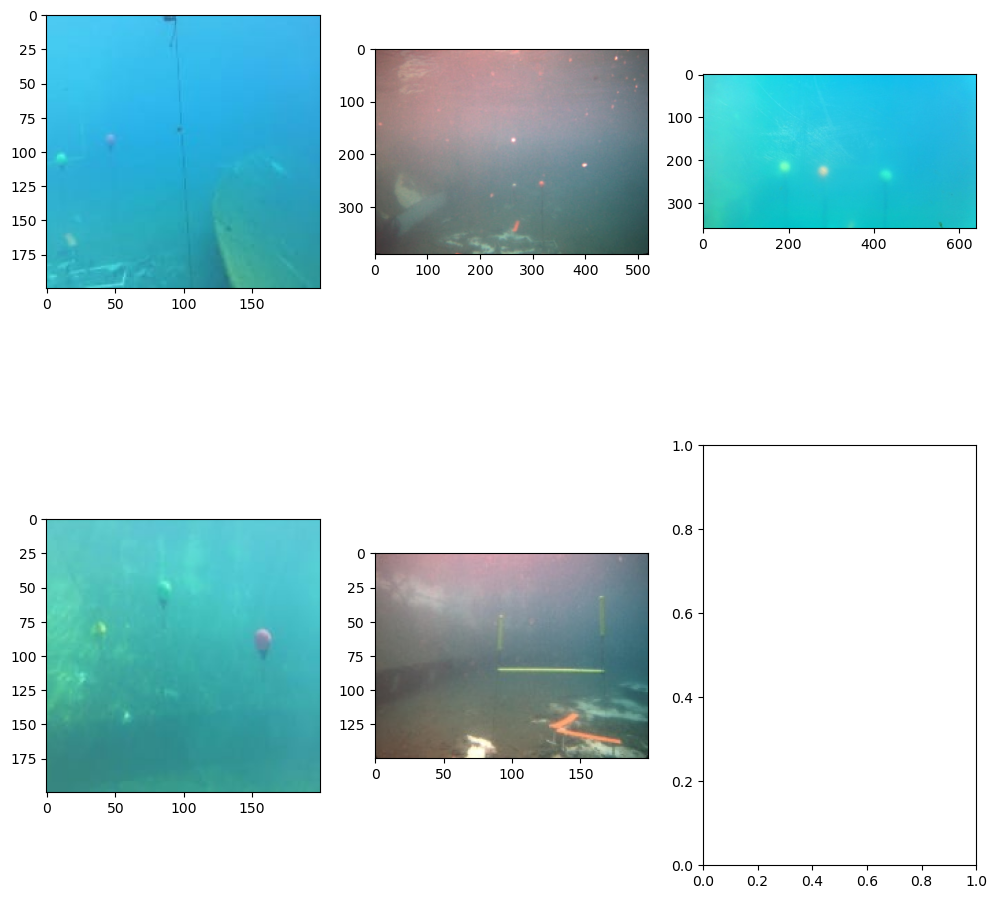

In [169]:
def show_image(img):
    _, axs = plt.subplots(2, 3, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(img, axs):
        ax.imshow(img)
    plt.show()

show_image(images)

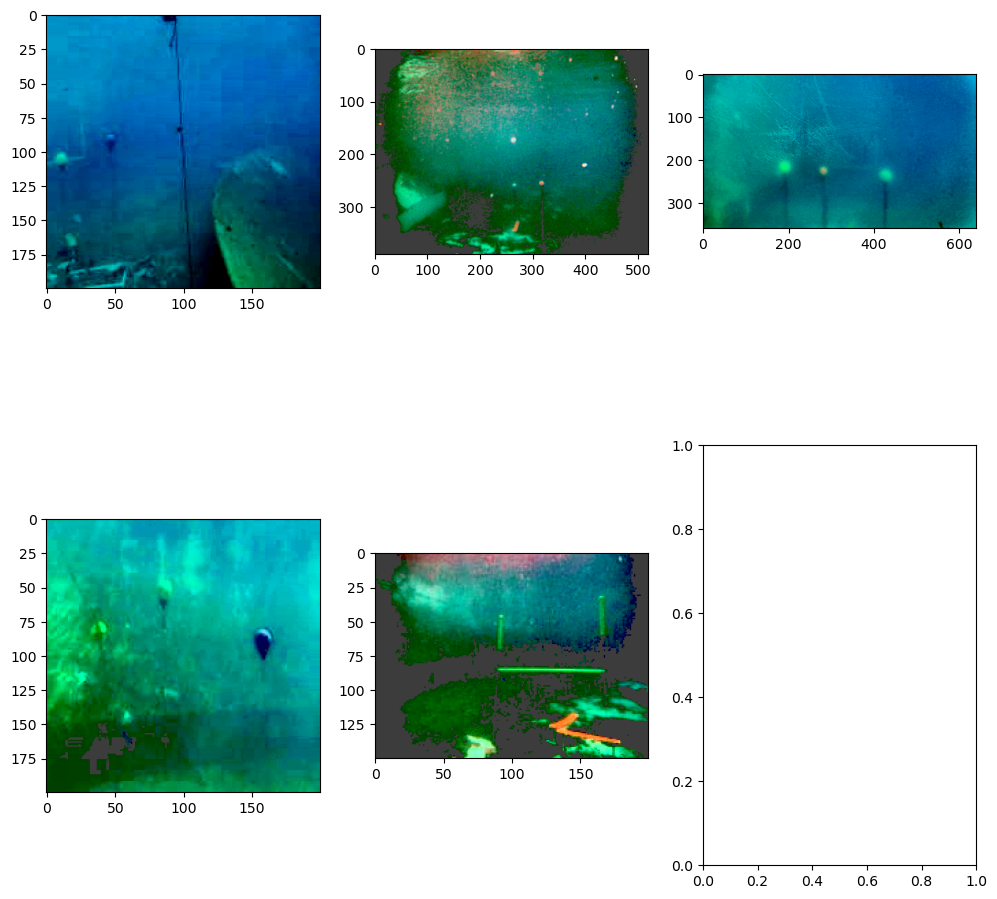

In [220]:
# one this can be observed that the images have a lot of blue tint and are not clear enough. We can reduce the blue tint and increase the clarity of the image.
import numpy as np
# pipeline
import albumentations as A

def adaptive_brightness_increase(image, dark_threshold=100, boost_value=60):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    average_brightness = np.mean(v)
    if average_brightness < dark_threshold:
        v_boosted = np.clip(v.astype(np.int16) + boost_value, 0, 255).astype(np.uint8)
        final_hsv = cv2.merge([h, s, v_boosted])
        brightened_image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return brightened_image
        
    else:
        return image

def color_correction(img):
    img = img.copy()
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    cl = clahe.apply((l*0.9).astype(np.uint8))
    ca = clahe.apply((a*0.8).astype(np.uint8))
    limg = cv2.merge((cl,ca,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

def pipeline(img):
    # prototype 1
    img = img.copy()
    img = color_correction(img)
    copy = img.copy()
    inverse = 255 - copy

    img = cv2.subtract(img, (inverse*0.8).astype(np.uint8))
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # img[:,:,2] = (img[:,:,2]*0.8).astype(np.uint8)
    # img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    img = adaptive_brightness_increase(img)
    # img = cv2.convertScaleAbs(img, alpha=1.5, beta=0.0)

    return img

enhanced_images = []
for img in images:
    enhanced_images.append(pipeline(img))
    # enhanced_images.append(A_pipeline(image=img)['image'])

show_image(enhanced_images)

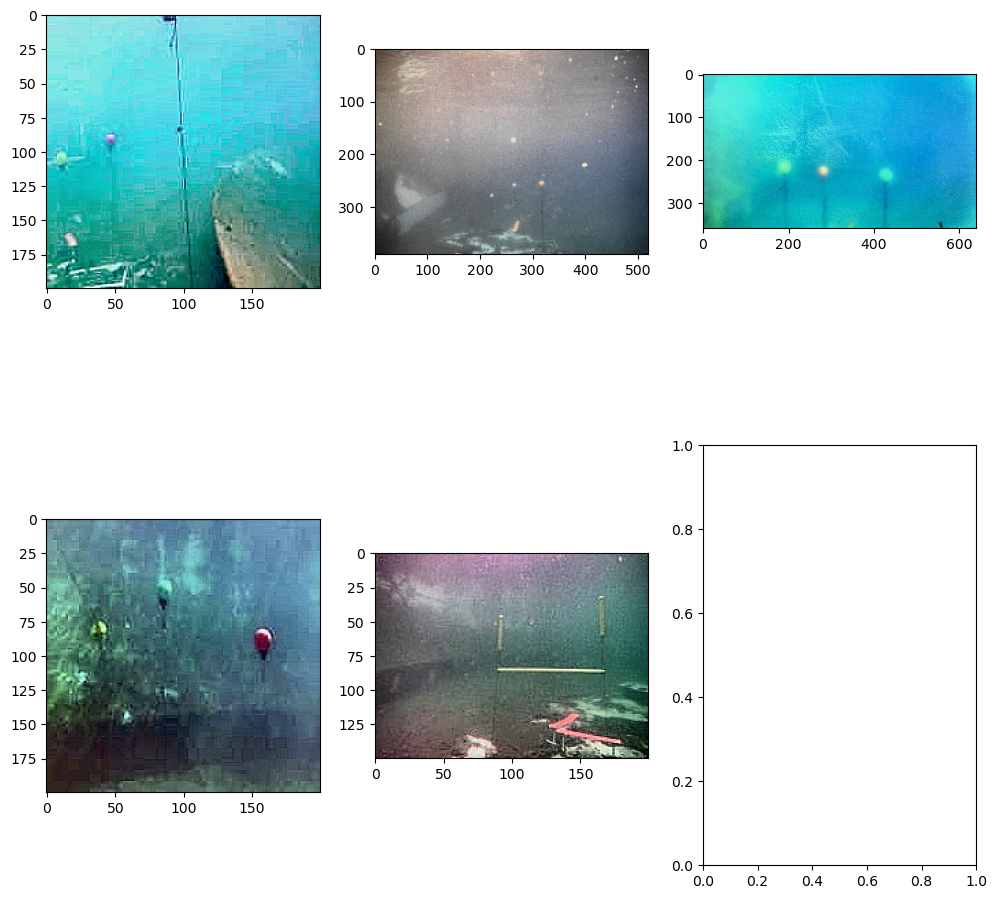

(200, 200, 3)

In [242]:
# prototype 2 --> Part 1
"""
This is the final pipeline which uses albumentations library to enhance the images.
1. RandomBrightnessContrast: This transform is used to randomly change the brightness and contrast of the image. This is useful to enhance the visibility of the image.
2. CLAHE: This transform is used to apply Contrast Limited Adaptive Histogram Equalization. This is useful to improve the contrast of the image as it homogenizes the brightness and color of the image.
3. AutoContrast: This transform is used to automatically adjust the contrast of the image.
4. Sharpen: This transform is used to sharpen the image. This is useful to enhance the edges of the image.
5. HueSaturationValue: This transform is used to change the hue, saturation and value of the image. This is useful to enhance the colors of the image.
"""
A_pipeline = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(4,4), p=1),
    A.AutoContrast(method="pil",p=1),
    A.Sharpen(alpha=(0.2, 0.3), lightness=(0.5, 0.6), p=1),
    A.HueSaturationValue(sat_shift_limit=30, p=1),
])

enhanced_images = []
for img in images:
    enhanced_images.append(A_pipeline(image=img)['image'])
show_image(enhanced_images)

enhanced_images[0].shape


Avg Blue: 188.10885, Avg Green: 185.372675, Avg Red: 71.426175
Avg Blue: 130.5758875739645, Avg Green: 128.4552761341223, Avg Red: 127.44109467455621
Avg Blue: 204.4215625, Avg Green: 181.9832986111111, Avg Red: 26.669427083333332
Avg Blue: 113.8203, Avg Green: 105.8045, Avg Red: 71.426675
Avg Blue: 110.92933333333333, Avg Green: 111.87073333333333, Avg Red: 103.2254


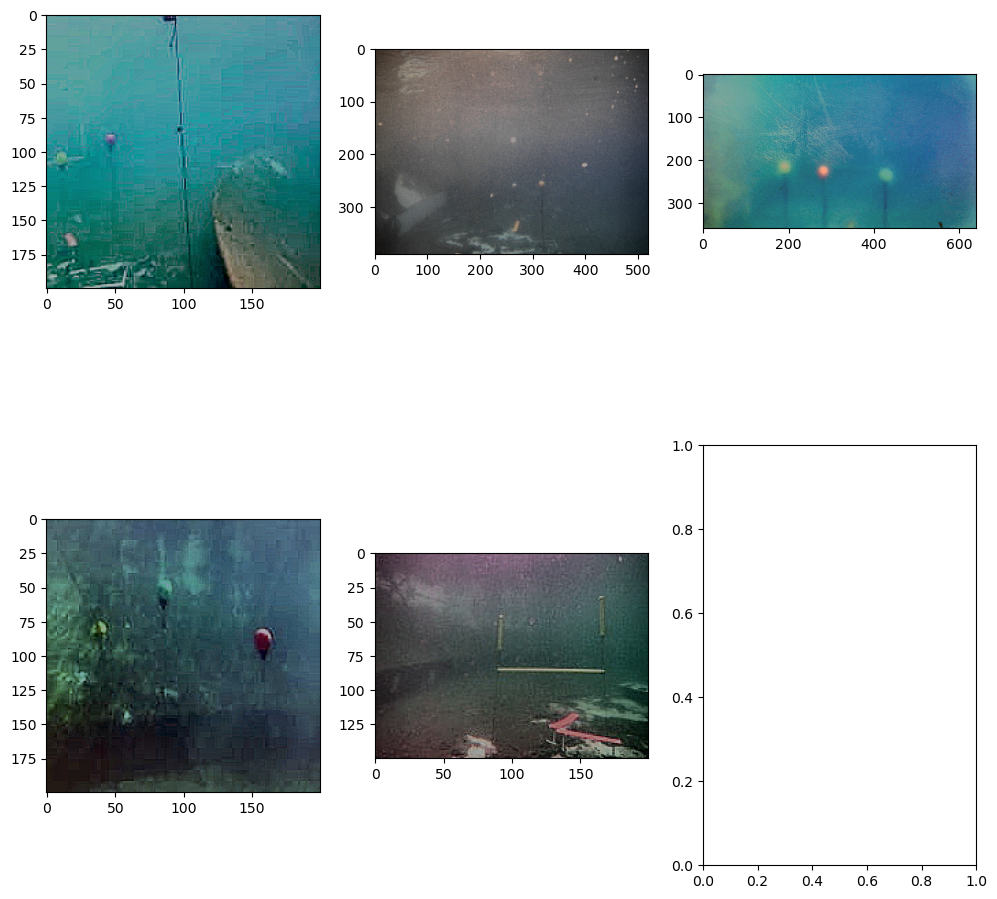

In [276]:
# prototype 2 --> Part 2

def adaptive_channel_color_decrease(img, threshold_blue=50, threshold_green=100, threshold_red=70):
    img = img.copy()
    r, g, b = cv2.split(img)
    avg_blue = np.mean(b)
    avg_green = np.mean(g)
    avg_red = np.mean(r)
    print(f"Avg Blue: {avg_blue}, Avg Green: {avg_green}, Avg Red: {avg_red}")
    if avg_blue > threshold_blue:
        b = (b*0.7).astype(np.uint8)
        img = cv2.merge([r, g, b])
    if avg_green > threshold_green:
        g = (g*0.7).astype(np.uint8)
        img = cv2.merge([r, g, b])
    if avg_red > threshold_red:
        r = (r*0.7).astype(np.uint8)
        img = cv2.merge([r, g, b])
    if avg_red < threshold_red:
        r = np.clip(r.astype(np.int16) + 30, 0, 255).astype(np.uint8)
        img = cv2.merge([r, g, b])
    return img

enhanced_images_part_2 = []

for img in enhanced_images:
    img = adaptive_channel_color_decrease(img)
    enhanced_images_part_2.append(img)

show_image(enhanced_images_part_2)
